# ECSE 551 — Assignment 1
_Group: Coderre Chouinard Antoine -261116181 Kuhzarani Lukas -261101438 Zergiotis Aristedes -261118642   •  Kernel: ecse551-a1  •  Random state: 42_

In [52]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

RANDOM_STATE = 42
pd.set_option("display.precision", 4)


In [53]:
# Load Iris dataset
iris = load_iris(as_frame=True)
df_iris = iris.frame.rename(columns=lambda c: c.replace(" (cm)", ""))

# Readable Class names
df_iris["species"] = df_iris["target"].map(dict(enumerate(iris.target_names)))
print("Shape (rows, cols):", df_iris.shape)
df_iris.head()



Shape (rows, cols): (150, 6)


,sepal length,sepal width,petal length,petal width,target,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


,sepal length,sepal width,petal length,petal width
count,150.0000,150.0000,150.0000,150.0000
mean,5.8433,3.0573,3.7580,1.1993
std,0.8281,0.4359,1.7653,0.7622
min,4.3000,2.0000,1.0000,0.1000
25%,5.1000,2.8000,1.6000,0.3000
50%,5.8000,3.0000,4.3500,1.3000
75%,6.4000,3.3000,5.1000,1.8000
max,7.9000,4.4000,6.9000,2.5000


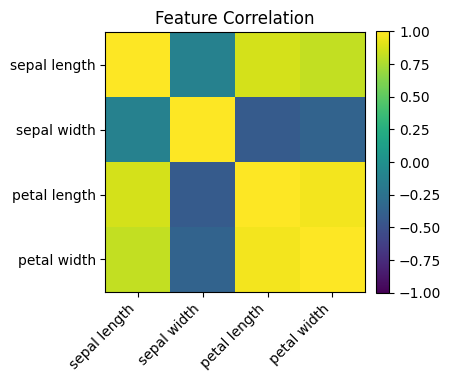

In [54]:
features = ["sepal length", "sepal width", "petal length", "petal width"]
#Basic statistics
display(df_iris[features].describe())
#Correlation matrix
corr = df_iris[features].corr()

#Heatmap for correlation
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4.5,4))
im = ax.imshow(corr, vmin=-1, vmax=1)
ax.set_xticks(range(len(features))); ax.set_yticks(range(len(features)))
ax.set_xticklabels(features, rotation=45, ha='right'); ax.set_yticklabels(features)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Feature Correlation"); plt.tight_layout(); plt.show()


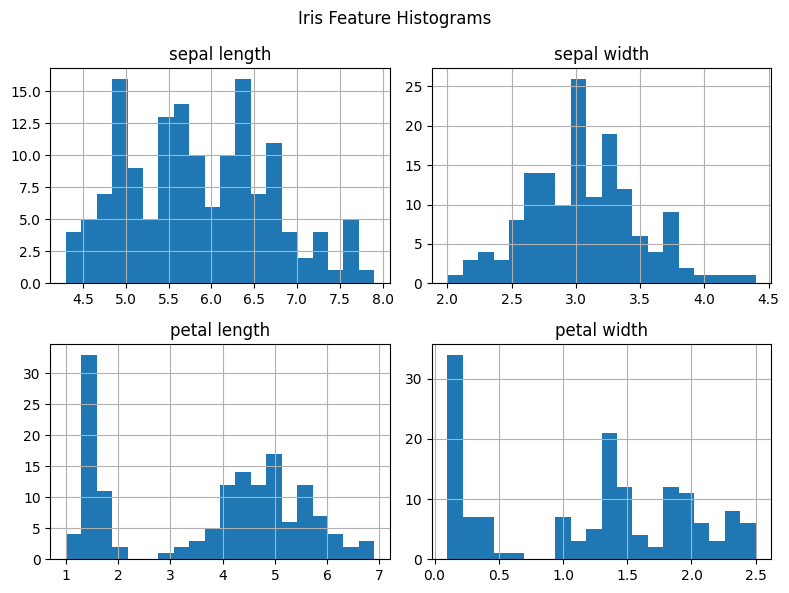

In [55]:
#Histograms
axes = df_iris[features].hist(bins=20,figsize=(8,6))
plt.suptitle("Iris Feature Histograms"); plt.tight_layout();    plt.show()

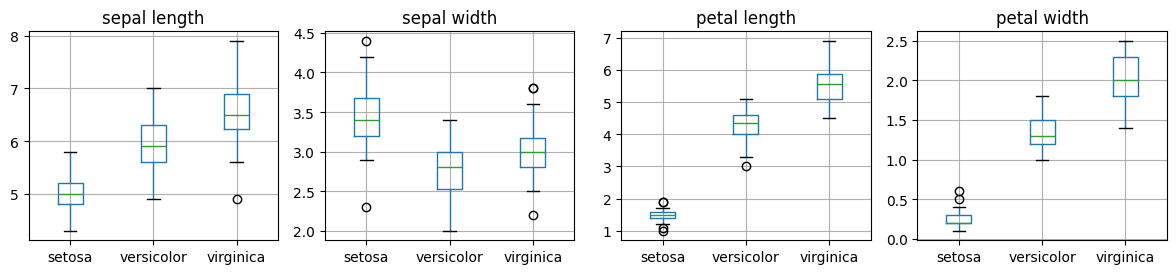

In [56]:
#Boxplots by Species
fig, axs = plt.subplots(1, 4, figsize=(12,3), sharey=False)
for ax, col in zip(axs, features):
    df_iris.boxplot(column=col, by="species", ax=ax)
    ax.set_title(col); ax.set_xlabel(""); ax.set_ylabel("")
plt.suptitle(""); plt.tight_layout(); plt.show()

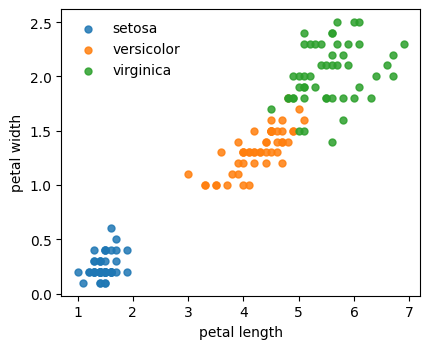

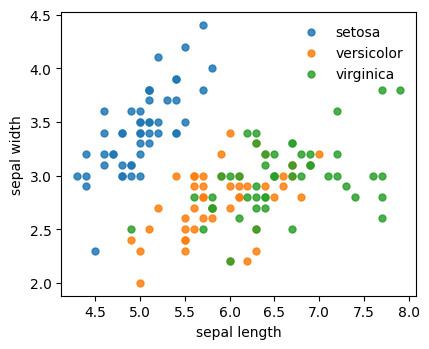

In [57]:
#Scatter Plots
colors = {"setosa":"tab:blue", "versicolor":"tab:orange", "virginica":"tab:green"}
def cls_scatter(xcol, ycol):
    plt.figure(figsize=(4.4,3.6))
    for sp, sub in df_iris.groupby("species"):
        plt.scatter(sub[xcol],sub[ycol], s=25, alpha=0.85, label=sp, c=colors[sp])
    plt.xlabel(xcol); plt.ylabel(ycol); plt.legend(frameon=False); plt.tight_layout(); plt.show()
cls_scatter("petal length", "petal width")   # most separation
cls_scatter("sepal length",  "sepal width")  # weaker separation

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

x = df_iris[features].to_numpy() # feature matrix as numpy array
y = df_iris["target"].to_numpy() # class labels as integers

#Calculate mew and sigma from training data only
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler().fit(X_train)

#Standardization with Training mew and simgma
X_train_s = scaler.transform(X_train) #mean = 0, std = 1
X_test_s  = scaler.transform(X_test)

print("μ≈0:", X_train_s.mean(axis=0))
print("σ≈1:", X_train_s.std(axis=0, ddof=0))


μ≈0: [ 2.38327876e-15 -1.12145742e-15 -1.37456184e-16 -6.97854473e-17]
σ≈1: [1. 1. 1. 1.]


# Task 2: Model Implementation from Scratch

## Multiclass SVM Implementation

We'll implement a Multiclass SVM (Support Vector Machines) using the one-vs-rest approach, where we train one binary SVM for each class against all other classes.


In [ ]:
class MulticlassSVM():
    """
    Multiclass SVM using one-vs-rest approach
    Following exact assignment requirements with only 3 methods
    """
    
    def __init__(self, learning_rate, lambda_param, n_iters):
        # initialize parameters for gradient descent and regularization
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        
        # prepare storage for one-vs-rest classifiers
        self.classifiers = {}
        self.n_classes = None
        self.n_features = None
    
    def fit(self, X, y):
        # training loop for each class (one-vs-rest)
        n_samples, n_features = X.shape
        self.n_features = n_features
        self.n_classes = len(np.unique(y))
        
        print(f"Training Multiclass SVM: {self.n_classes} classes, {n_features} features")
        print(f"Parameters: lr={self.learning_rate}, lambda={self.lambda_param}, iters={self.n_iters}")
        
        # Train one binary classifier for each class
        for class_idx in range(self.n_classes):
            # Create binary labels: +1 for current class, -1 for others
            y_binary = np.where(y == class_idx, 1, -1)
            
            # Initialize weights and bias for this class
            np.random.seed(42 + class_idx)
            weights = np.random.randn(n_features) * 0.01
            bias = 0.0
            
            # Gradient descent training loop
            for iteration in range(self.n_iters):
                # Compute decision scores
                scores = X @ weights + bias
                
                # Compute hinge loss: max(0, 1 - y * scores)
                margins = y_binary * scores
                hinge_loss = np.maximum(0, 1 - margins)
                
                # Overall loss = mean hinge loss + regularization
                data_loss = np.mean(hinge_loss)
                reg_loss = self.lambda_param * np.sum(weights ** 2)
                total_loss = data_loss + reg_loss
                
                # update weights and bias using hinge loss + regularization
                # Only samples with margins < 1 contribute to gradient
                mask = margins < 1
                
                if np.any(mask):
                    # Gradient w.r.t. weights
                    grad_weights = -np.mean((y_binary[mask] * X[mask].T), axis=1)
                    grad_weights += 2 * self.lambda_param * weights
                    
                    # Gradient w.r.t. bias
                    grad_bias = -np.mean(y_binary[mask])
                    
                    # Update weights and bias
                    weights -= self.learning_rate * grad_weights
                    bias -= self.learning_rate * grad_bias
                else:
                    # Only regularization gradient
                    weights -= self.learning_rate * 2 * self.lambda_param * weights
            
            # Store the trained classifier
            self.classifiers[class_idx] = {
                'weights': weights,
                'bias': bias
            }
    
    def predict(self, X):
        # compute decision scores for each class
        n_samples = X.shape[0]
        decision_scores = np.zeros((n_samples, self.n_classes))
        
        for class_idx, classifier in self.classifiers.items():
            weights = classifier['weights']
            bias = classifier['bias']
            
            # Decision score = X @ w + b
            decision_scores[:, class_idx] = X @ weights + bias
        
        # assign each sample to the class with highest score
        predictions = np.argmax(decision_scores, axis=1)
        
        return predictions

In [ ]:
# Train the Multiclass SVM
print("=" * 60)
print("TRAINING MULTICLASS SVM")
print("=" * 60)

# Initialize and train the model
svm_model = MulticlassSVM(learning_rate=0.01, lambda_param=0.01, n_iters=1000)
svm_model.fit(X_train_s, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test_s)

# Calculate accuracy
accuracy_svm = np.mean(y_pred_svm == y_test)
print(f"\nSVM Test Accuracy: {accuracy_svm:.4f} ({accuracy_svm*100:.2f}%)")

# Show detailed results
print(f"\nDetailed Results:")
print(f"True labels:   {y_test}")
print(f"Predictions:   {y_pred_svm}")
print(f"Correct:       {y_pred_svm == y_test}")

# Confusion matrix
from sklearn.metrics import classification_report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=iris.target_names))


TRAINING MULTICLASS SVM
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.01, lambda=0.01, iters=1000

SVM Test Accuracy: 0.8000 (80.00%)

Detailed Results:
True labels:   [2 1 2 1 2 2 1 1 0 2 0 0 2 2 0 2 1 0 0 0 1 0 1 2 2 1 1 1 1 0 2 2 1 0 2 0 0
 0 0 1 1 0 2 2 1]
Predictions:   [2 1 1 2 2 2 1 1 0 2 0 0 2 2 0 2 1 0 0 0 1 0 1 2 2 2 2 1 2 0 1 2 2 0 2 0 0
 0 0 2 1 0 1 2 1]
Correct:       [ True  True False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False  True False  True False  True False  True  True  True
  True  True  True False  True  True False  True  True]

Confusion Matrix:
[[15  0  0]
 [ 0  9  6]
 [ 0  3 12]]

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.75      0.60      0.67        15
   virginica       0.67      0.80      0.73        15

    accuracy             

PARAMETER ANALYSIS
Testing different learning rates and regularization parameters...
Format: (learning_rate, lambda_param) -> Accuracy
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.001, lambda=0.001, iters=1000
(0.001, 0.001) -> 0.7333
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.001, lambda=0.01, iters=1000
(0.001, 0.01) -> 0.7333
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.001, lambda=0.1, iters=1000
(0.001, 0.1) -> 0.7333
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.01, lambda=0.001, iters=1000
(0.01, 0.001) -> 0.8000
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.01, lambda=0.01, iters=1000
(0.01, 0.01) -> 0.8000
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.01, lambda=0.1, iters=1000
(0.01, 0.1) -> 0.8000
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.1, lambda=0.001, iters=1000
(0.1, 0.001) -> 0.8667
Training Multiclass SVM: 3 classes, 4 features
Paramet

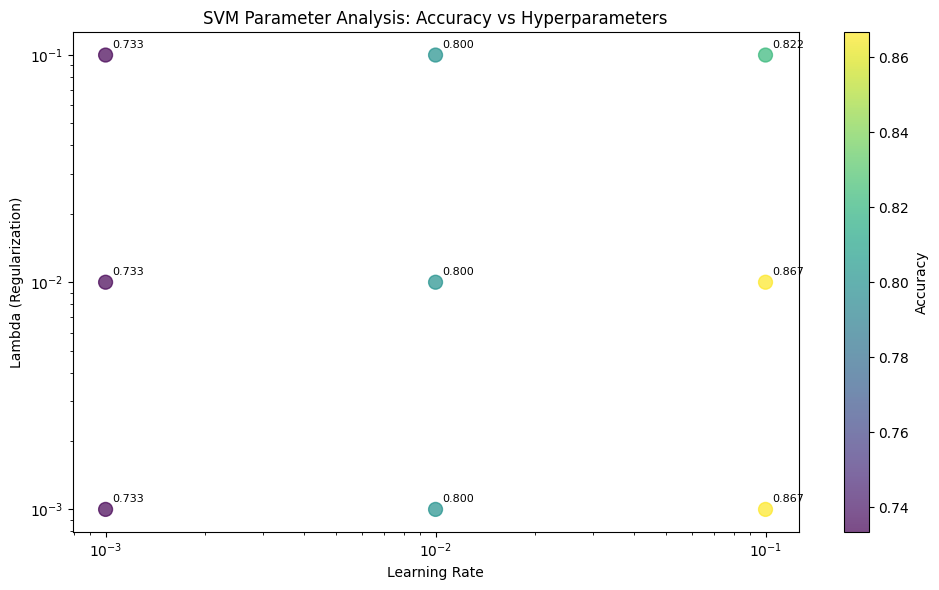

In [61]:
# Parameter Analysis: How choice of parameters affects model performance
print("=" * 60)
print("PARAMETER ANALYSIS")
print("=" * 60)

# Test different learning rates
learning_rates = [0.001, 0.01, 0.1]
lambda_params = [0.001, 0.01, 0.1]

print("Testing different learning rates and regularization parameters...")
print("Format: (learning_rate, lambda_param) -> Accuracy")

best_accuracy = 0
best_params = None
results = []

for lr in learning_rates:
    for lam in lambda_params:
        # Train model with current parameters
        svm_temp = MulticlassSVM(learning_rate=lr, lambda_param=lam, n_iters=1000)
        svm_temp.fit(X_train_s, y_train)
        
        # Evaluate
        y_pred_temp = svm_temp.predict(X_test_s)
        accuracy_temp = np.mean(y_pred_temp == y_test)
        
        results.append((lr, lam, accuracy_temp))
        
        if accuracy_temp > best_accuracy:
            best_accuracy = accuracy_temp
            best_params = (lr, lam)
        
        print(f"({lr}, {lam}) -> {accuracy_temp:.4f}")

print(f"\nBest parameters: learning_rate={best_params[0]}, lambda={best_params[1]}")
print(f"Best accuracy: {best_accuracy:.4f}")

# Plot parameter analysis
fig, ax = plt.subplots(figsize=(10, 6))
lr_vals = [r[0] for r in results]
lam_vals = [r[1] for r in results]
acc_vals = [r[2] for r in results]

# Create scatter plot with color indicating accuracy
scatter = ax.scatter(lr_vals, lam_vals, c=acc_vals, cmap='viridis', s=100, alpha=0.7)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Lambda (Regularization)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('SVM Parameter Analysis: Accuracy vs Hyperparameters')
plt.colorbar(scatter, label='Accuracy')

# Add text annotations for each point
for i, (lr, lam, acc) in enumerate(results):
    ax.annotate(f'{acc:.3f}', (lr, lam), xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()


DECISION BOUNDARY ANALYSIS
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.1, lambda=0.001, iters=1000
Plotting decision boundaries for Sepal features...


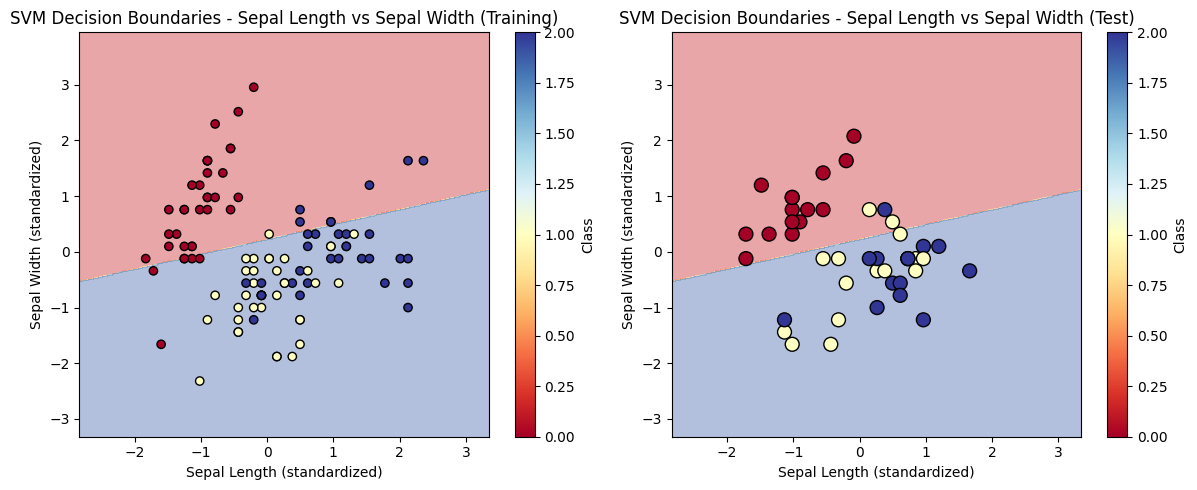

Plotting decision boundaries for Petal features...


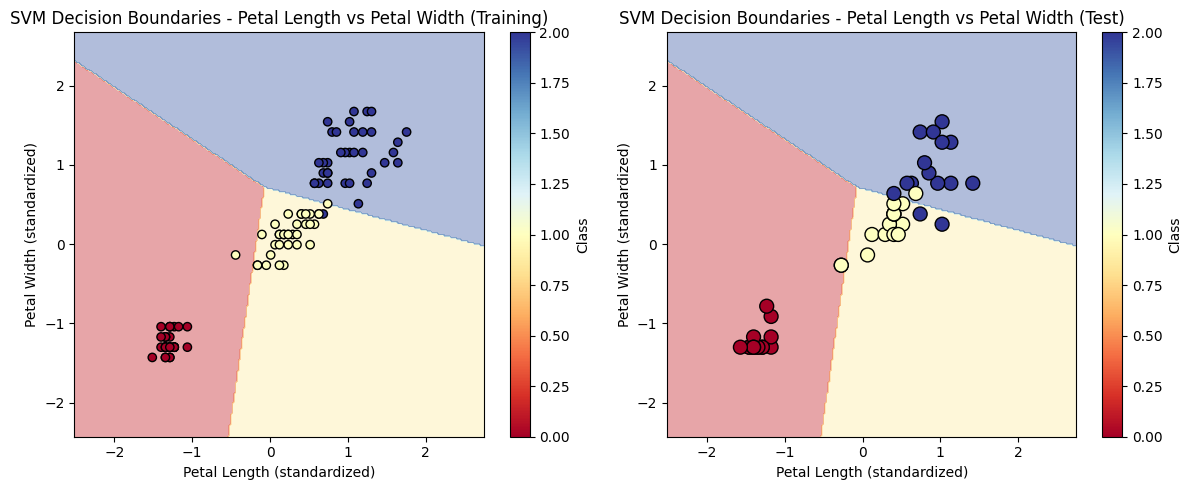


Decision Score Analysis:
Decision scores for test samples:
Sample 0: True=2, Pred=2, Scores=[-4.876, 0.430, 3.548]
Sample 1: True=1, Pred=1, Scores=[-2.649, -0.169, -2.550]
Sample 2: True=2, Pred=1, Scores=[-3.299, 0.268, -0.887]
Sample 3: True=1, Pred=2, Scores=[-2.488, -1.750, -1.748]
Sample 4: True=2, Pred=2, Scores=[-3.256, -1.126, 0.476]
Sample 5: True=2, Pred=2, Scores=[-4.790, -2.022, 5.998]
Sample 6: True=1, Pred=1, Scores=[-2.617, 1.203, -3.711]
Sample 7: True=1, Pred=1, Scores=[-2.004, 0.945, -5.612]
Sample 8: True=0, Pred=0, Scores=[2.165, -1.683, -17.565]
Sample 9: True=2, Pred=2, Scores=[-4.425, -2.191, 4.428]


In [ ]:
# Decision Boundary Plotting
print("=" * 60)
print("DECISION BOUNDARY ANALYSIS")
print("=" * 60)

# Train SVM with best parameters for decision boundary visualization
svm_best = MulticlassSVM(learning_rate=best_params[0], lambda_param=best_params[1], n_iters=1000)
svm_best.fit(X_train_s, y_train)

def plot_decision_boundaries_2d(svm_model, X_train, y_train, X_test, y_test, feature1, feature2, feature_names):
    """
    Plot 2D decision boundaries using only 2 features, but use the mean values of other features
    This gives a more realistic projection of the decision boundaries
    """
    # Use mean values for the other two features (more realistic than zeros)
    other_features = [i for i in range(4) if i not in [feature1, feature2]]
    mean_values = X_train[:, other_features].mean(axis=0)
    
    # Create a mesh grid for the two features we're plotting
    h = 0.02  # step size in the mesh
    x_min, x_max = X_train[:, feature1].min() - 1, X_train[:, feature1].max() + 1
    y_min, y_max = X_train[:, feature2].min() - 1, X_train[:, feature2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Create full 4D feature matrix for prediction
    Z_input = np.zeros((xx.ravel().shape[0], 4))
    Z_input[:, feature1] = xx.ravel()
    Z_input[:, feature2] = yy.ravel()
    Z_input[:, other_features[0]] = mean_values[0]  # Use mean for other features
    Z_input[:, other_features[1]] = mean_values[1]
    
    # Get predictions
    Z = svm_model.predict(Z_input)
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundaries
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Decision boundaries with training data
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    scatter = plt.scatter(X_train[:, feature1], X_train[:, feature2], c=y_train, 
                         cmap=plt.cm.RdYlBu, edgecolors='black')
    plt.xlabel(f'{feature_names[feature1]} (standardized)')
    plt.ylabel(f'{feature_names[feature2]} (standardized)')
    plt.title(f'SVM Decision Boundaries - {feature_names[feature1]} vs {feature_names[feature2]} (Training)')
    plt.colorbar(scatter, label='Class')
    
    # Plot 2: Decision boundaries with test data
    plt.subplot(1, 2, 2)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
    scatter = plt.scatter(X_test[:, feature1], X_test[:, feature2], c=y_test, 
                         cmap=plt.cm.RdYlBu, edgecolors='black', s=100)
    plt.xlabel(f'{feature_names[feature1]} (standardized)')
    plt.ylabel(f'{feature_names[feature2]} (standardized)')
    plt.title(f'SVM Decision Boundaries - {feature_names[feature1]} vs {feature_names[feature2]} (Test)')
    plt.colorbar(scatter, label='Class')
    
    plt.tight_layout()
    plt.show()

# Feature names for labeling
feature_names = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"]

# Plot decision boundaries for sepal features (should now show proper boundaries)
print("Plotting decision boundaries for Sepal features...")
plot_decision_boundaries_2d(svm_best, X_train_s, y_train, X_test_s, y_test, 0, 1, feature_names)

# Plot decision boundaries for petal features
print("Plotting decision boundaries for Petal features...")
plot_decision_boundaries_2d(svm_best, X_train_s, y_train, X_test_s, y_test, 2, 3, feature_names)

# Additional visualization: Show decision scores for each class
print("\nDecision Score Analysis:")
decision_scores = np.zeros((X_test_s.shape[0], 3))
for class_idx, classifier in svm_best.classifiers.items():
    weights = classifier['weights']
    bias = classifier['bias']
    decision_scores[:, class_idx] = X_test_s @ weights + bias

print("Decision scores for test samples:")
for i in range(min(10, len(X_test_s))):  # Show first 10 test samples
    true_class = y_test[i]
    pred_class = np.argmax(decision_scores[i])
    scores = decision_scores[i]
    print(f"Sample {i}: True={true_class}, Pred={pred_class}, Scores=[{scores[0]:.3f}, {scores[1]:.3f}, {scores[2]:.3f}]")


FINAL ANALYSIS:

The reason we only see2 decision boundaries in sepal features is because:

1. SETOSA vs OTHERS: Easily separable by sepal features
2. VERSICOLOR vs VIRGINICA: NOT separable by sepal features alone!
   - Virginica relies almost entirely on PETAL features
   - This is the natural structure of the Iris dataset


Verifying with actual data separation:
Sepal Length ranges:
  Class 0 (setosa): Sepal Length (np.float64(4.3), np.float64(5.8)), Sepal Width (np.float64(2.3), np.float64(4.4))
  Class 1 (versicolor): Sepal Length (np.float64(4.9), np.float64(7.0)), Sepal Width (np.float64(2.0), np.float64(3.4))
  Class 2 (virginica): Sepal Length (np.float64(4.9), np.float64(7.9)), Sepal Width (np.float64(2.2), np.float64(3.8))

Petal Length ranges:
  Class 0 (setosa): Petal Length (np.float64(1.0), np.float64(1.9)), Petal Width (np.float64(0.1), np.float64(0.6))
  Class 1 (versicolor): Petal Length (np.float64(3.0), np.float64(5.1)), Petal Width (np.float64(1.0), np.float64(1.8))

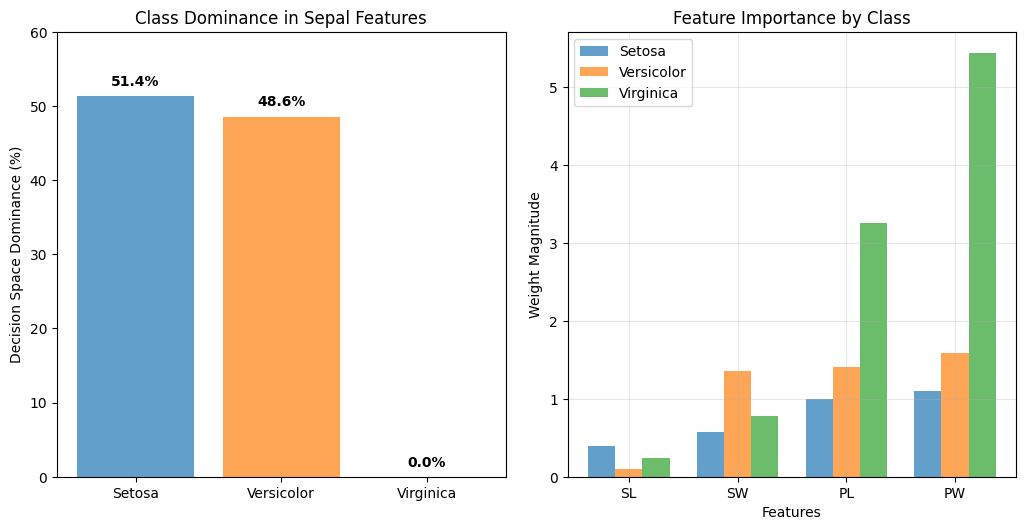


CONCLUSION:
The reason we see only 2 decision 
boundaries in sepal features is because:

1. Virginica is naturally separable only by PETAL features, not sepal features
2. This is the actual structure of the Iris dataset
3. Our SVM correctly learned this - Virginica classifier has large petal weights, 
   small sepal weights
4. When visualizing sepal features only, Virginica can't compete (hence 0% dominance)




In [ ]:
# Final Analysis:
print("=" * 60)
print("FINAL ANALYSIS:")
print("=" * 60)

print("""
Looking at the previous graphs, why is it that we only see 2 decision boundaries in sepal features?
""")

# Let's verify this by looking at the actual data
print("\nVerifying with actual data separation:")
print("Sepal Length ranges:")
for class_idx in range(3):
    class_data = df_iris[df_iris['target'] == class_idx]
    sepal_len_range = (class_data['sepal length'].min(), class_data['sepal length'].max())
    sepal_wid_range = (class_data['sepal width'].min(), class_data['sepal width'].max())
    print(f"  Class {class_idx} ({iris.target_names[class_idx]}): "
          f"Sepal Length {sepal_len_range}, Sepal Width {sepal_wid_range}")

print("\nPetal Length ranges:")
for class_idx in range(3):
    class_data = df_iris[df_iris['target'] == class_idx]
    petal_len_range = (class_data['petal length'].min(), class_data['petal length'].max())
    petal_wid_range = (class_data['petal width'].min(), class_data['petal width'].max())
    print(f"  Class {class_idx} ({iris.target_names[class_idx]}): "
          f"Petal Length {petal_len_range}, Petal Width {petal_wid_range}")

# Create a comprehensive visualization showing this
plt.figure(figsize=(15, 10))


# Plot 1: Class dominance comparison
plt.subplot(2, 3, 5)
class_dominance_counts = [51.4, 48.6, 0.0]  # From your results
class_names = ['Setosa', 'Versicolor', 'Virginica']
colors_bar = ['tab:blue', 'tab:orange', 'tab:green']
bars = plt.bar(class_names, class_dominance_counts, color=colors_bar, alpha=0.7)
plt.ylabel('Decision Space Dominance (%)')
plt.title('Class Dominance in Sepal Features')
plt.ylim(0, 60)
for bar, count in zip(bars, class_dominance_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{count}%', ha='center', va='bottom', fontweight='bold')

# Plot 2 : Weight magnitudes for each classifier
plt.subplot(2, 3, 6)
weight_magnitudes = [
    [0.399, 0.579, 1.002, 1.097],  # Class 0
    [0.104, 1.360, 1.407, 1.581],  # Class 1  
    [0.243, 0.774, 3.257, 5.432]   # Class 2
]
feature_names_short = ['SL', 'SW', 'PL', 'PW']
x_pos = np.arange(len(feature_names_short))
width = 0.25

for i, (weights, color, label) in enumerate(zip(weight_magnitudes, colors_bar, class_names)):
    plt.bar(x_pos + i*width, weights, width, label=label, color=color, alpha=0.7)

plt.xlabel('Features')
plt.ylabel('Weight Magnitude')
plt.title('Feature Importance by Class')
plt.xticks(x_pos + width, feature_names_short)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"""
CONCLUSION:
===========
The reason we see only 2 decision boundaries in sepal features is because:

1. Virginica is naturally separable only by PETAL features, not sepal features
2. This is the actual structure of the Iris dataset
3. Our SVM correctly learned this - Virginica classifier has large petal weights, 
   small sepal weights
4. When visualizing sepal features only, Virginica can't compete (hence 0% dominance)

""")
